<a href="https://colab.research.google.com/github/Bix4UMD/BIOI611_lab/blob/main/docs/BIOI611_scRNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#

## Install required R packages

In [1]:
# # Install the remotes package
# if (!requireNamespace("remotes", quietly = TRUE)) {
#   install.packages("remotes")
# }
# # Install Seurat
# if (!requireNamespace("Seurat", quietly = TRUE)) {
#     remotes::install_github("satijalab/seurat", "seurat5", quiet = TRUE)
# }
# # Install BiocManager
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# # Install SingleR package
# if (!require("hdf5r", quietly = TRUE)){
#     BiocManager::install("hdf5r")
# }
# # Install SingleR package
# if (!require("presto", quietly = TRUE)){
#     remotes::install_github("immunogenomics/presto")
# }
# # Install SingleR package
# if (!require("SingleR", quietly = TRUE)){
#     BiocManager::install("SingleR")
# }
# if (!require("celldex", quietly = TRUE)){
#     BiocManager::install("celldex")
# }
# if (!require("SingleCellExperiment", quietly = TRUE)){
#     BiocManager::install("SingleCellExperiment")
# }
# if (!require("scater", quietly = TRUE)){
#     BiocManager::install("scater")
# }

In [2]:
## Installing the R packages could take around 51 minutes
## To speed up this process, you can download the R lib files
## saved from a working Google Colab session
## https://drive.google.com/file/d/1eN-Raj3Hlnml68ACZQ36VQRGZxFclneL/view?usp=sharing
system("gdown 1eN-Raj3Hlnml68ACZQ36VQRGZxFclneL", intern = TRUE)

character(0)

In [3]:
system("md5sum BIOI611_custom_R_lib_Nov_2025.tar.gz", intern = TRUE)

[1] "fcfbd50c028468ec37d8654fda0eaec6  BIOI611_custom_R_lib_Nov_2025.tar.gz"

In [4]:
## required by scater package
system("apt-get install libx11-dev libcairo2-dev", intern = TRUE)
system("tar zxvf BIOI611_custom_R_lib_Nov_2025.tar.gz")

[1] "Reading package lists..."                                       
[2] "Building dependency tree..."                                    
[3] "Reading state information..."                                   
[4] "libcairo2-dev is already the newest version (1.16.0-5ubuntu2)." 
[5] "libx11-dev is already the newest version (2:1.7.5-1ubuntu0.3)." 
[6] "libx11-dev set to manually installed."                          
[7] "0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded."

In [6]:
.libPaths(c("/content/usr/local/lib/R/site-library", .libPaths()))
.libPaths()

[1] "/content/usr/local/lib/R/site-library"
[2] "/usr/local/lib/R/site-library"        
[3] "/usr/lib/R/site-library"              
[4] "/usr/lib/R/library"

## Load required R packages

In [7]:
library(Seurat)
library(dplyr)
library(SingleR)
library(celldex)
library(scater)
library(SingleCellExperiment)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantile

In [8]:
list.files()

[1] "BIOI611_custom_R_lib_Nov_2025.tar.gz"
[2] "sample_data"                         
[3] "sessionInfo.txt"                     
[4] "usr"

In [9]:
# https://drive.google.com/file/d/1-CvmcLvKMYW-OcLuGfFuGQMK2b5_VMFk/view?usp=drive_link
# Download "filtered_feature_bc_matrix.h5"
# Output of cellranger
system("gdown 1-CvmcLvKMYW-OcLuGfFuGQMK2b5_VMFk", intern = TRUE)

character(0)

In [10]:
system("md5sum filtered_feature_bc_matrix.h5", intern = TRUE)

[1] "360fc0760ebb9e6dd253d808a427b20d  filtered_feature_bc_matrix.h5"

In [11]:
count_mtx_scrna <- Read10X_h5("filtered_feature_bc_matrix.h5")
# If you have the filtered_feature_bc_matrix/ folder, you can use
# Read10X to create 'count_mtx_scrna'
# system("mkdir filtered_feature_bc_matrix/; mv filtered_feature_bc_matrix.zip filtered_feature_bc_matrix")
# system("cd filtered_feature_bc_matrix; unzip filtered_feature_bc_matrix.zip")
# count_mtx_scrna <- Read10X("filtered_feature_bc_matrix/")

In [12]:
class(count_mtx_scrna)

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

The dgCMatrix class is a specific data structure in R's Matrix package, designed to store sparse matrices in a memory-efficient format. Sparse matrices are those with many zeros, making them ideal for high-dimensional data in applications like bioinformatics, where gene expression matrices often contain a lot of zeroes.

> Why Use dgCMatrix?

*   **Memory Efficiency**: Storing only non-zero values saves memory, especially in high-dimensional matrices.
*   **Computational Speed**: Some operations on sparse matrices can be faster, as computations are limited to non-zero entries.



In [13]:
print(format(object.size(count_mtx_scrna), units = "MB"))

[1] "168.7 Mb"


In [14]:
# Check a few genes in the first 20 cells
count_mtx_scrna[c("CD3D", "TCL1A", "MS4A1"), 100:140]

  [[ suppressing 41 column names ‘AACCATGCACTCAAGT-1’, ‘AACCATGGTAGCTTGT-1’, ‘AACCATGTCAATCCGA-1’ ... ]]



3 x 41 sparse Matrix of class "dgCMatrix"
                                                                              
CD3D  8 1 . . . 3 . 2 10  . 3 . . . 2 7 1 . . . 1 1  . 8 . . 2 4 . . . 12 11 .
TCL1A . . . . . . 6 .  .  . . . . . . . . . . . . . 10 . . . . . . . .  .  . .
MS4A1 . . . . . . 9 .  . 16 . . . . . . . . . . . .  5 . . . . . . . .  .  . .
                     
CD3D   . 5 . .  . 3 .
TCL1A  . . . .  . . .
MS4A1 20 . . . 39 . .

In [15]:
# non-normalized da# Initialize the Seurat object with the raw count matrix
pbmc <- CreateSeuratObject(counts = count_mtx_scrna,
                        project = "pbmc5k",
                        min.cells = 3, min.features = 200)
pbmc

An object of class Seurat 
24785 features across 4884 samples within 1 assay 
Active assay: RNA (24785 features, 0 variable features)
 1 layer present: counts

## Understand Seurat object


> Seurat slots
https://github.com/satijalab/seurat/wiki/seurat



In [16]:
str(pbmc)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 1
  .. .. .. .. ..$ counts:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:14449622] 6 17 42 62 79 83 85 94 100 109 ...
  .. .. .. .. .. .. ..@ p       : int [1:4885] 0 3378 5344 5581 8581 10897 13921 16902 20299 22669 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 24785 4884
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:14449622] 1 1 4 1 1 2 1 1 1 1 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ cells     :Formal class 'LogMap' [package "SeuratObject"] with 1 slot
  .. .. .. .. .. ..@ .Data: logi [1:4884, 1] TRUE TRUE TRUE TRUE TRUE TRUE ...
  .. .. .. .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. .. .. .. ..$ : c

In [18]:
slotNames(pbmc)

[1] "assays"       "meta.data"    "active.assay" "active.ident" "graphs"      
 [6] "neighbors"    "reductions"   "images"       "project.name" "misc"        
[11] "version"      "commands"     "tools"

### Access Seurat object

In [20]:
pbmc@active.assay

[1] "RNA"

In [21]:
class(pbmc@meta.data)
head(pbmc@meta.data, 4)

[1] "data.frame"

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACCCATCAGATGCT-1,pbmc5k,11578,3378
AAACGAAAGTGCTACT-1,pbmc5k,5655,1966
AAACGAAGTCGTAATC-1,pbmc5k,14728,237
AAACGAAGTTGCCAAT-1,pbmc5k,10903,3000


In [22]:
colSums(pbmc@assays$RNA$counts)[1:3]

AAACCCATCAGATGCT-1 AAACGAAAGTGCTACT-1 AAACGAAGTCGTAATC-1 
             11578               5655              14728

In [23]:
Layers(pbmc)

[1] "counts"

## Data preprocessing

In [24]:
# Use $ operator to add columns to object metadata.
pbmc$percent.mt <- PercentageFeatureSet(pbmc,
                           pattern = "^MT-")


In [25]:
colnames(pbmc@meta.data)

[1] "orig.ident"   "nCount_RNA"   "nFeature_RNA" "percent.mt"

In [26]:
head(pbmc, 4)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCCATCAGATGCT-1,pbmc5k,11578,3378,3.62756953
AAACGAAAGTGCTACT-1,pbmc5k,5655,1966,4.29708223
AAACGAAGTCGTAATC-1,pbmc5k,14728,237,0.02715915
AAACGAAGTTGCCAAT-1,pbmc5k,10903,3000,4.89773457


In [27]:
pbmc

An object of class Seurat 
24785 features across 4884 samples within 1 assay 
Active assay: RNA (24785 features, 0 variable features)
 1 layer present: counts

In [28]:
NewVlnPlot <- function(seurat_obj, col = 3){
  # Use violin plot to visualize QC metrics
  tem_plots <- VlnPlot(
    seurat_obj,
    features = c("nFeature_RNA", "nCount_RNA", "percent.mt"),
    combine = FALSE  # return list of ggplot objects
  )
  # Apply theme to each plot
  tem_plots <- lapply(tem_plots, function(x) x + NoLegend())   # OR + theme_bw()
  # Combine again
  patchwork::wrap_plots(tem_plots, ncol = 3)
}

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


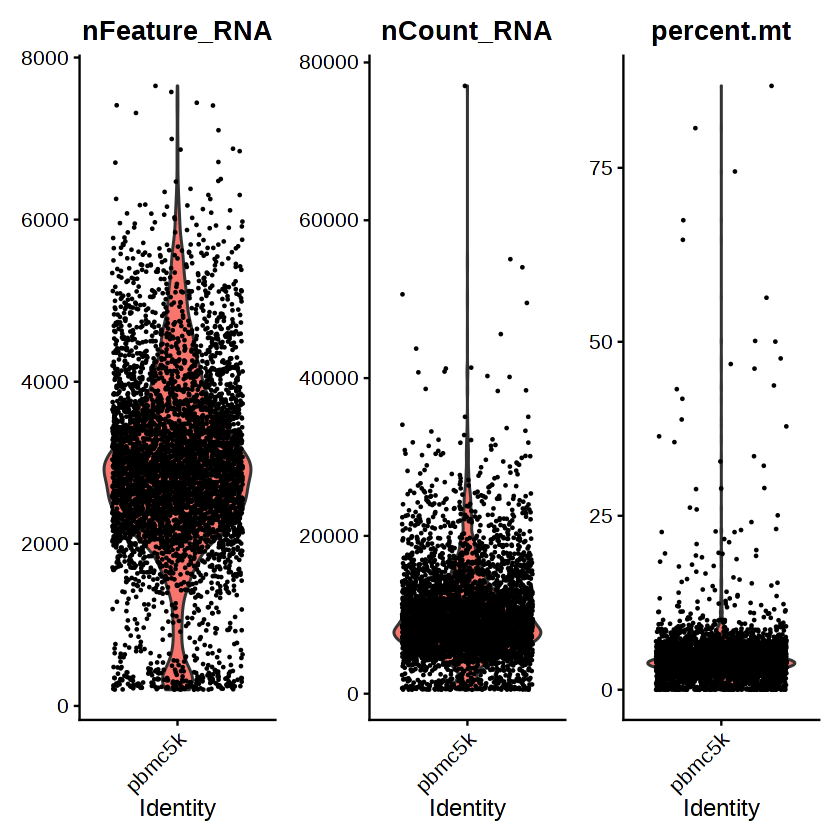

In [29]:
# VlnPlot(
#     pbmc,
#     features = c("nFeature_RNA", "nCount_RNA", "percent.mt"),
#     col = 3
#   )

NewVlnPlot(pbmc, col = 3)

### How to read the Violin Plot


*   Shape: Each violin plot shows the distribution of values for each feature across the cells in your dataset. The shape of the plot indicates the density of cells with particular values for that feature.

    Wider sections indicate more cells with those values.
    Narrow sections indicate fewer cells with those values.

*   Vertical Axis: Represents the range of values for each feature. For instance:

`nFeature_RNA` and `nCount_RNA`: Higher values suggest more gene diversity and RNA content, respectively.

`percent.mt`: Higher values indicate higher mitochondrial content, which may point to stressed or dying cells.

*   Horizontal Axis (Groups): If your dataset is separated into clusters or groups (e.g., cell types or conditions), each group will have its own violin, allowing you to compare distributions between groups.


###  How to interpret QC plot


`nFeature_RNA`: The number of unique features (genes) detected per cell.

Extremely high values could suggest potential doublets (two cells mistakenly captured as one), as two cells would have more unique genes combined.

Low number of detected genes - potential ambient mRNA (not real cells)


`nCount_RNA`: The total number of RNA molecules (or unique molecular identifiers, UMIs) detected per cell.

Higher counts generally indicate higher RNA content, but they could also result from cell doublets.
Cells with very low nCount_RNA might represent poor-quality cells with low RNA capture, while very high counts may also suggest doublets.

`percent.mt`: The percentage of reads mapping to mitochondrial genes.

High mitochondrial content often indicates cell stress or apoptosis, as damaged cells tend to release mitochondrial RNA.

Filtering cells with high `percent.mt` values is common to exclude potentially dying cells.

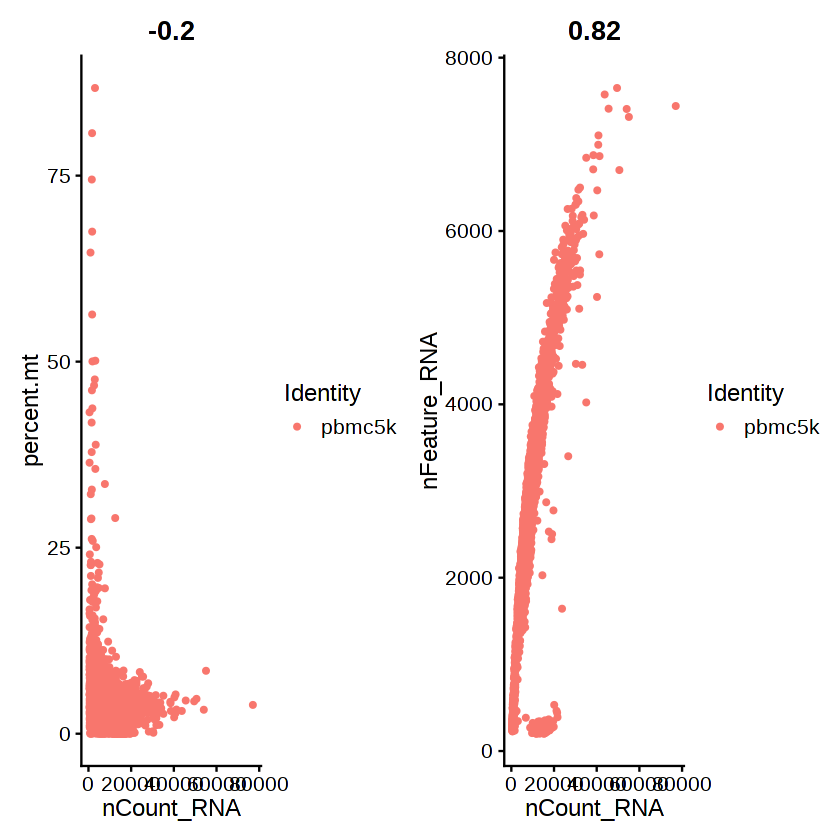

In [30]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [31]:
# Load necessary libraries
library(Seurat)
library(ggplot2)

# Define the function to calculate median and MAD values
calculate_thresholds <- function(seurat_obj) {
  # Extract relevant columns
  nFeature_values <- seurat_obj@meta.data$nFeature_RNA
  nCount_values <- seurat_obj@meta.data$nCount_RNA
  percent_mt_values <- seurat_obj@meta.data$percent.mt

  # Calculate medians and MADs
  nFeature_median <- median(nFeature_values, na.rm = TRUE)
  nFeature_mad <- mad(nFeature_values, constant = 1, na.rm = TRUE)

  nCount_median <- median(nCount_values, na.rm = TRUE)
  nCount_mad <- mad(nCount_values, constant = 1, na.rm = TRUE)

  percent_mt_median <- median(percent_mt_values, na.rm = TRUE)
  percent_mt_mad <- mad(percent_mt_values, constant = 1, na.rm = TRUE)

  # Calculate thresholds for horizontal lines
  thresholds <- list(
    nFeature_upper = nFeature_median + 4 * nFeature_mad,
    nFeature_lower = nFeature_median - 4 * nFeature_mad,
    nCount_upper = nCount_median + 4 * nCount_mad,
    nCount_lower = nCount_median - 4 * nCount_mad,
    percent_mt_upper = percent_mt_median + 4 * percent_mt_mad
  )

  return(thresholds)
}

# Calculate thresholds
thresholds <- calculate_thresholds(pbmc)


In [32]:
thresholds

$nFeature_upper
[1] 5243.5

$nFeature_lower
[1] 583.5

$nCount_upper
[1] 19044

$nCount_lower
[1] -1224

$percent_mt_upper
[1] 8.447837

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


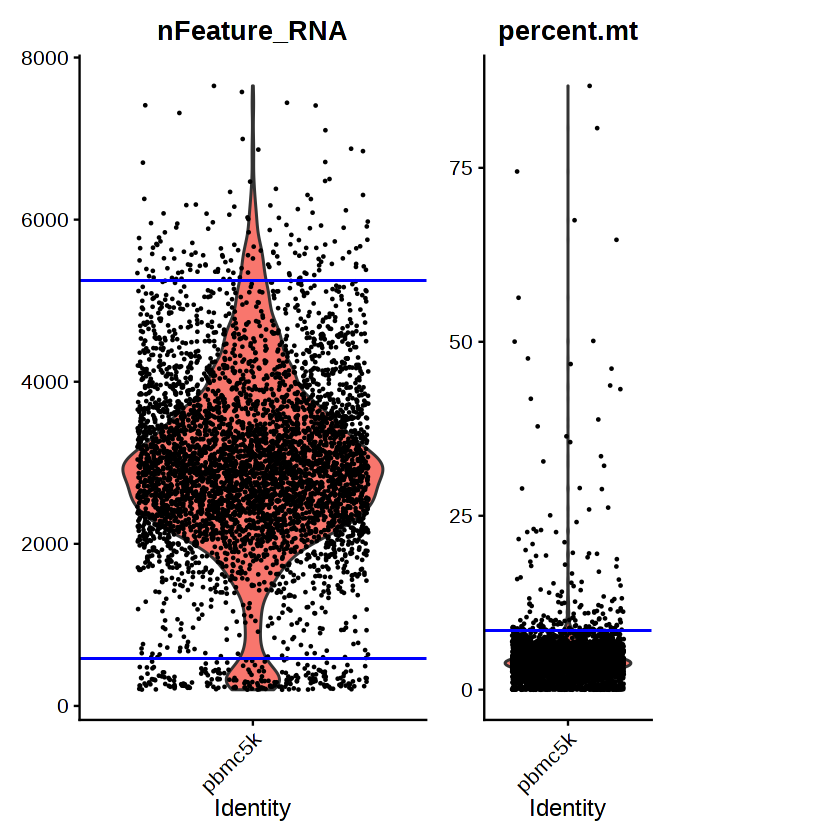

In [33]:
vplot1 <- VlnPlot(pbmc, features = c("nFeature_RNA"), ncol = 2) +
   geom_hline(yintercept = thresholds$nFeature_upper,
              color = "blue", linetype = "solid") +
   geom_hline(yintercept = thresholds$nFeature_lower,
              color = "blue", linetype = "solid") +
              theme(legend.position="none")
vplot2 <- VlnPlot(pbmc, features = c("percent.mt"), ncol = 2) +
   geom_hline(yintercept = thresholds$percent_mt_upper,
              color = "blue", linetype = "solid") +
              theme(legend.position="none")
vplot1 + vplot2

### Filter out potential doublets, empty droplets and dying cells

In [34]:
pbmc <- subset(pbmc,
                subset =  nFeature_RNA > thresholds$nCount_lower &
                nFeature_RNA < thresholds$nFeature_upper &
                percent.mt < thresholds$percent_mt_upper)


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


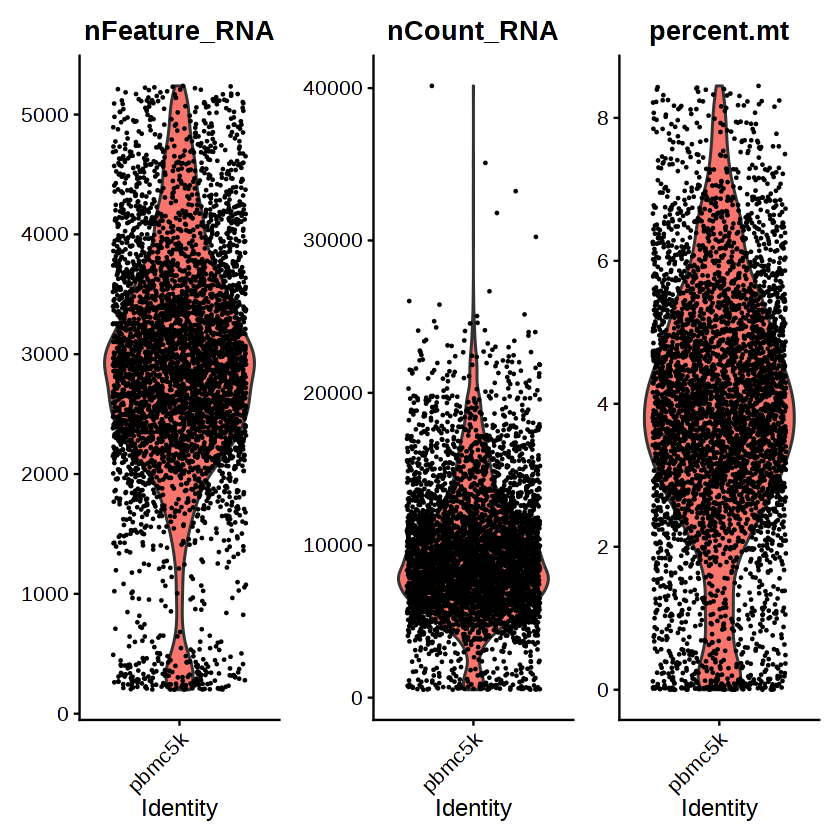

In [35]:
# Use violin plot to visualize QC metrics after QC
# VlnPlot(pbmc,
#         features = c("nFeature_RNA", "nCount_RNA", "percent.mt"),
#         ncol = 3)
NewVlnPlot(pbmc, col = 3)

Instead of using an arbitrary number, you can also use statistical algorithm to predict doublets and empty droplets to filter the cells, such as `DoubletFinder` and `EmptyDrops`.



### Normalization and Scaling of the data

### Normalization

After removing unwanted cells from the dataset, the next step is to normalize the data. By default, a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. In Seurat v5, Normalized values are stored in `pbmc[["RNA"]]$data`.



In [36]:
pbmc <- NormalizeData(pbmc) # normalization.method = "LogNormalize", scale.factor = 10000

Normalizing layer: counts



While this method of normalization is standard and widely used in scRNA-seq analysis, global-scaling relies on an assumption that each cell originally contains the same number of RNA molecules.

Next, we identify a subset of features that show high variation across cells in the dataset—meaning they are highly expressed in some cells and lowly expressed in others. Prior work, including our own, has shown that focusing on these variable genes in downstream analyses can enhance the detection of biological signals in single-cell datasets.

The approach used in Seurat improves upon previous versions by directly modeling the inherent mean-variance relationship in single-cell data. This method is implemented in the FindVariableFeatures() function, which, by default, selects 2,000 variable features per dataset. These features will then be used in downstream analyses, such as PCA.

In [37]:
pbmc <- FindVariableFeatures(pbmc,
                selection.method = "vst",
                nfeatures = 2000)


Finding variable features for layer counts



When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


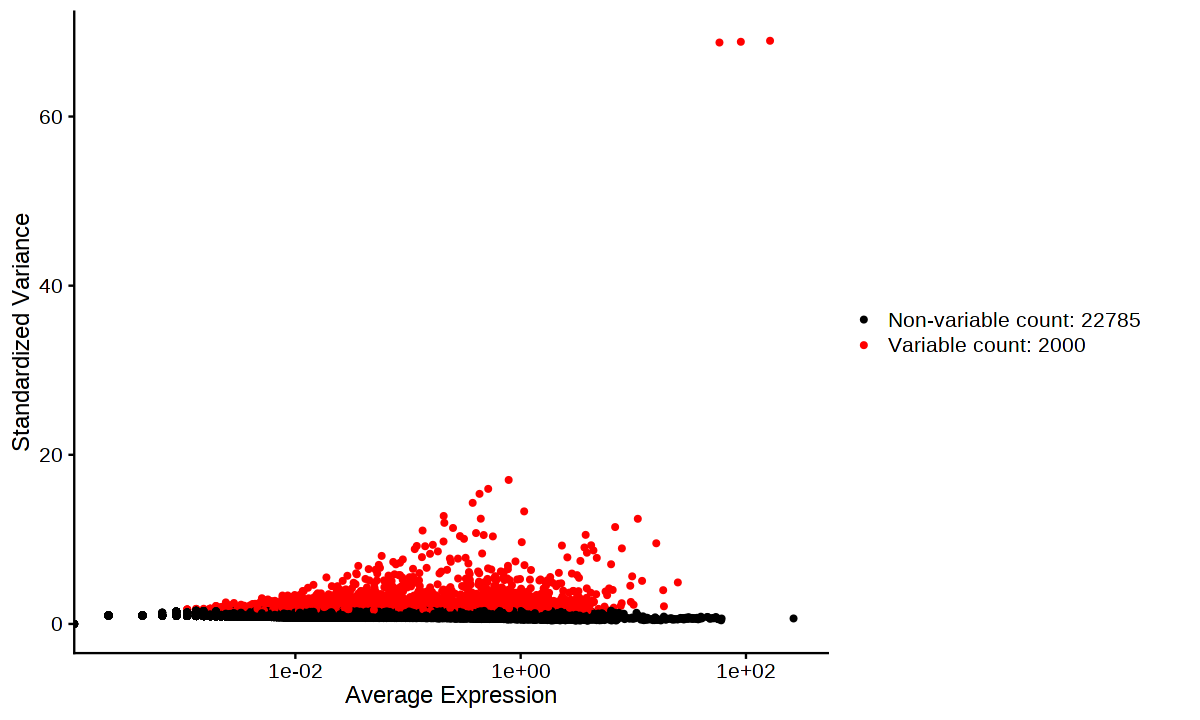

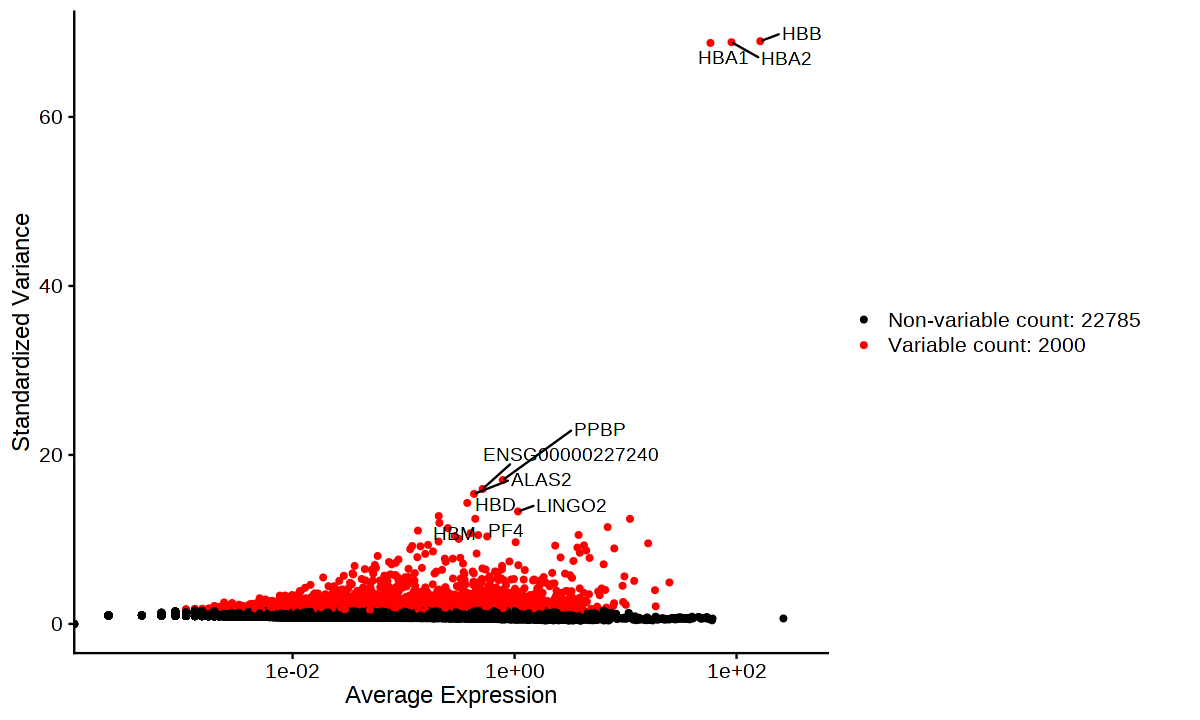

In [38]:
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)
options(repr.plot.width=10, repr.plot.height= 6)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
print(plot1)
print(plot2)

### Scaling the data

Next, we apply a linear transformation (`scaling`) that is a standard pre-processing step prior to dimensional reduction techniques like PCA. The `ScaleData()` function:

Shifts the expression of each gene, so that the mean expression across cells is 0
Scales the expression of each gene, so that the variance across cells is 1

This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate

The results of this are stored in `pbmc[["RNA"]]$scale.data`

By default, only variable features are scaled.
You can specify the features argument to scale additional features.


In [39]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



## Perform linear dimensional reduction


In [40]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CD247, IL32, IL7R, RORA, CAMK4, LTB, INPP4B, STAT4, BCL2, ANK3 
	   ZEB1, LEF1, TRBC1, CARD11, THEMIS, BACH2, MLLT3, RNF125, RASGRF2, NR3C2 
	   NELL2, PDE3B, LINC01934, ENSG00000290067, PRKCA, TAFA1, PYHIN1, CTSW, CSGALNACT1, SAMD3 
Negative:  LYZ, FCN1, IRAK3, SLC8A1, CLEC7A, PLXDC2, IFI30, S100A9, SPI1, CYBB 
	   MNDA, LRMDA, FGL2, VCAN, CTSS, RBM47, CSF3R, MCTP1, NCF2, TYMP 
	   CYRIA, CST3, HCK, SLC11A1, WDFY3, S100A8, MS4A6A, MPEG1, LST1, CSTA 
PC_ 2 
Positive:  CD247, S100A4, STAT4, NKG7, CST7, CTSW, GZMA, SYTL3, RNF125, SAMD3 
	   NCALD, MYO1F, MYBL1, KLRD1, PLCB1, TGFBR3, PRF1, GNLY, RAP1GAP2, RORA 
	   CCL5, HOPX, FGFBP2, YES1, PYHIN1, FNDC3B, GNG2, SYNE1, KLRF1, SPON2 
Negative:  BANK1, MS4A1, CD79A, FCRL1, PAX5, IGHM, AFF3, LINC00926, NIBAN3, EBF1 
	   IGHD, BLK, CD22, OSBPL10, HLA-DQA1, COL19A1, GNG7, KHDRBS2, RUBCNL, TNFRSF13C 
	   COBLL1, RALGPS2, TCL1A, BCL11A, CDK14, CD79B, PLEKHG1, HLA-DQB1, IGKC, BLNK 
PC_ 3 
Positive:  TUBB1, GP9, GP1BB, PF4, CAVIN

You have several useful ways to visualize both cells and features that define the PCA, including `VizDimReduction()`, `DimPlot()`, and `DimHeatmap()`.




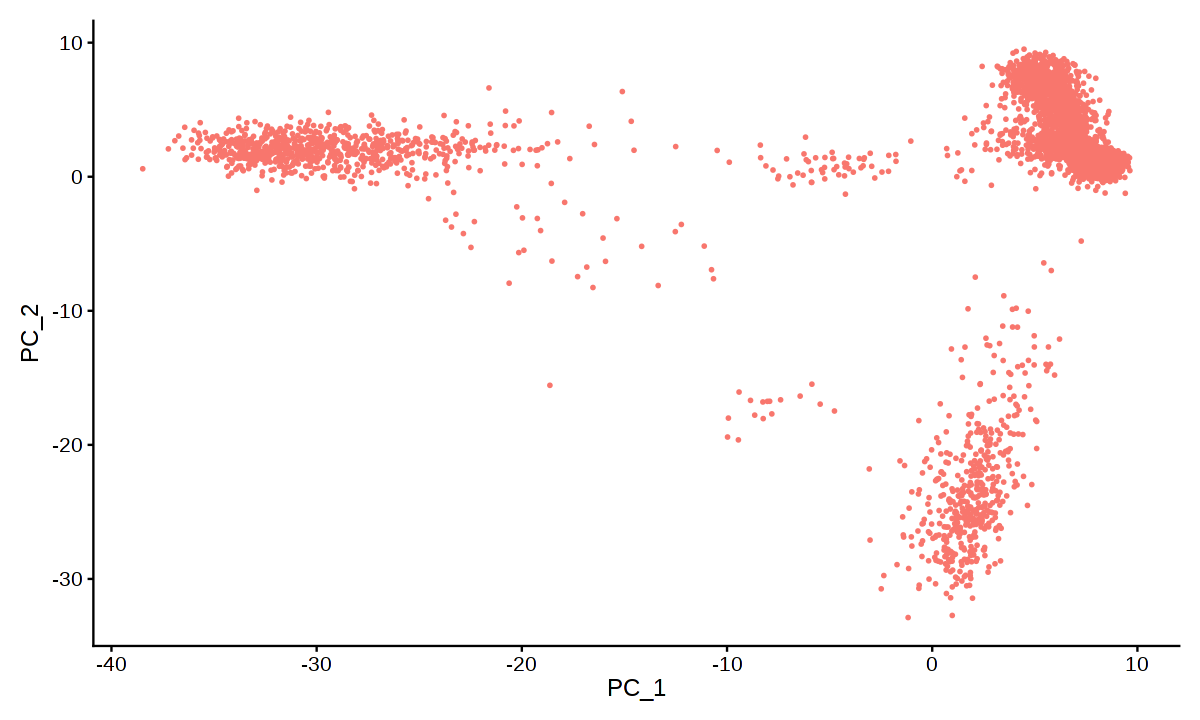

In [41]:
DimPlot(pbmc, reduction = "pca") + NoLegend()

`DimHeatmap()` draws a heatmap focusing on a principal component. Both cells and genes are sorted by their principal component scores

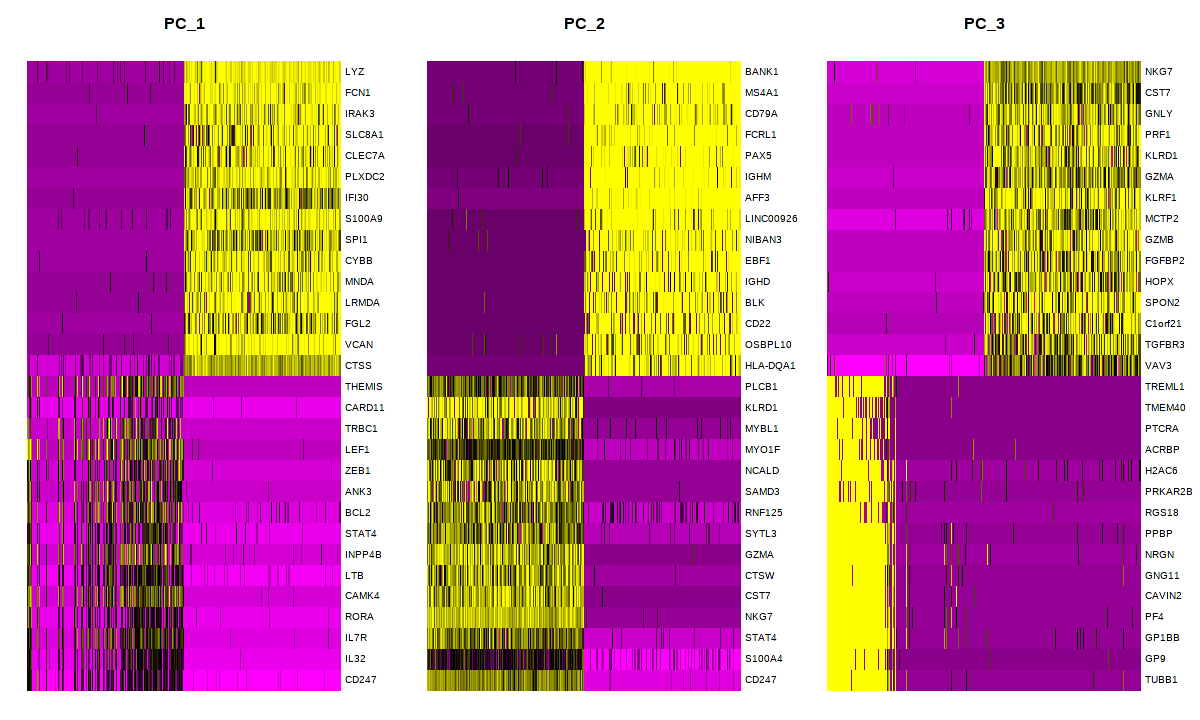

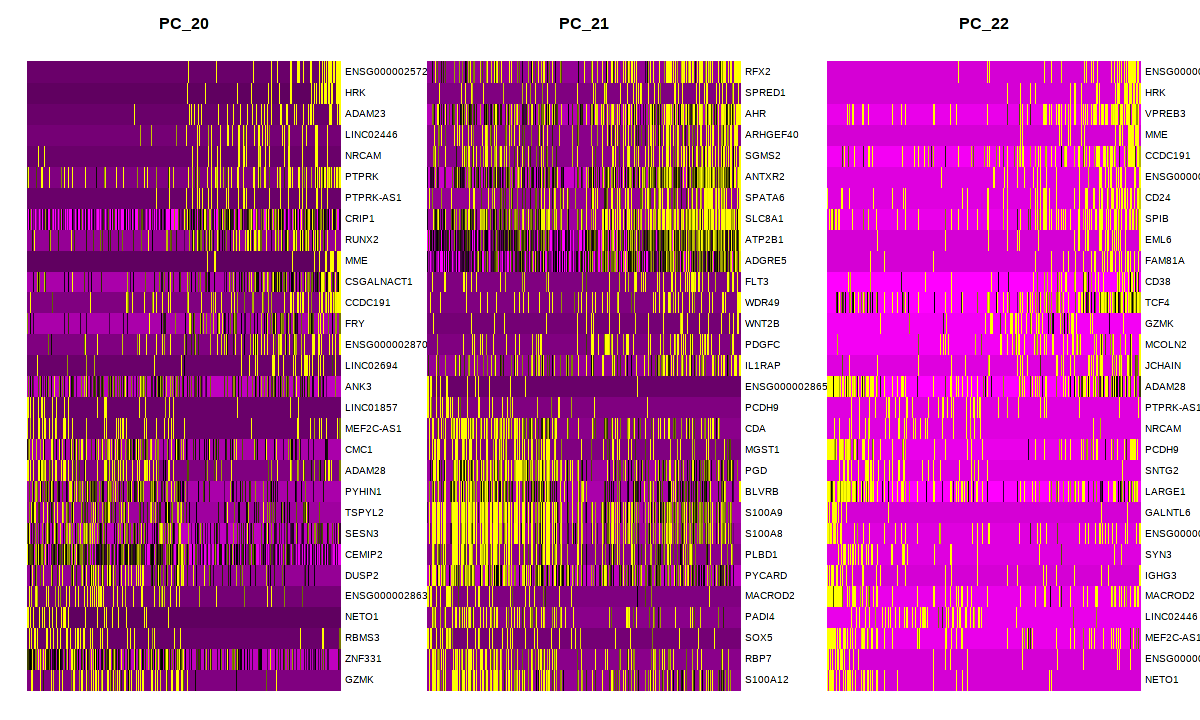

In [42]:
DimHeatmap(pbmc, dims = 1:3, cells = 500, balanced = TRUE)
DimHeatmap(pbmc, dims = 20:22, cells = 500, balanced = TRUE)


## Determine the ‘dimensionality’ of the dataset

The elbow plot is a useful tool for determining the number of principal components (PCs) needed to capture the majority of variation in the data. It displays the standard deviation of each PC, with the "elbow" point typically serving as the threshold for selecting the most informative PCs. However, identifying the exact location of the elbow can be somewhat subjective.

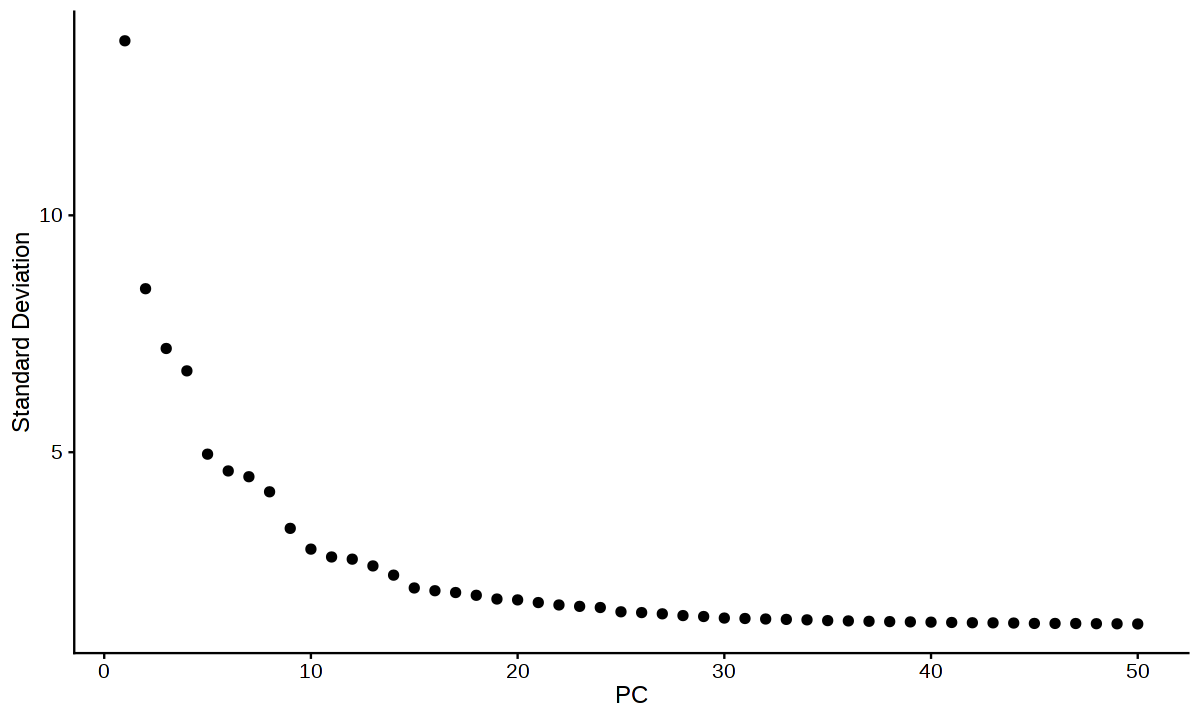

In [44]:
ElbowPlot(pbmc,  ndims = 50)

In [45]:
# Determine the percentage of variation associated with each PC
pct_var <- pbmc[["pca"]]@stdev / sum(pbmc[["pca"]]@stdev) * 100

# Calculate cumulative percentages for each PC
cumu_pct <- cumsum(pct_var)

# Identify the first PC where cumulative percentage exceeds 90% and individual variance is less than 5%
pc_number <- which(cumu_pct > 90 & pct_var < 5)[1]

pc_number

[1] 41

## Cluster the cells

 Seurat embeds cells in a graph structure - for example a K-nearest neighbor (KNN) graph, with edges drawn between cells with similar feature expression patterns, and then attempt to partition this graph into highly interconnected `quasi-cliques` or `communities`.

 Seurat first constructs a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods (Jaccard similarity). This step is performed using the `FindNeighbors()` function, and takes as input the previously defined dimensionality of the dataset.

 To cluster the cells, Seurat next applies modularity optimization techniques such as the Louvain algorithm (default) or SLM [SLM, Blondel et al., Journal of Statistical Mechanics], to iteratively group cells together, with the goal of optimizing the standard modularity function. The FindClusters() function implements this procedure, and contains a resolution parameter that sets the `granularity` of the downstream clustering, with increased values leading to a greater number of clusters. We find that setting this parameter between 1 typically returns good results for single-cell datasets of around 5k cells. Optimal resolution often increases for larger datasets. The clusters can be found using the `Idents()` function.

In [47]:
pbmc <- FindNeighbors(pbmc, dims = 1:pc_number)
pbmc <- FindClusters(pbmc, resolution = 0.2)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4559
Number of edges: 184776

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9568
Number of communities: 12
Elapsed time: 0 seconds


In [48]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACCCATCAGATGCT-1 AAACGAAAGTGCTACT-1 AAACGAAGTCGTAATC-1 AAACGAAGTTGCCAAT-1 
                 0                  1                  8                  6 
AAACGAATCCGAGGCT-1 
                 4 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11

## Run non-linear dimensional reduction (UMAP/tSNE)

To visualize and explore these datasets, Seurat  offers several non-linear dimensional reduction techniques, such as tSNE and UMAP.

The goal of tSNE/UMAP is to learn underlying structure in the dataset, in order to place similar cells together in low-dimensional space. Therefore, cells that are grouped together within graph-based clusters determined above should co-localize on these dimension reduction plots.


In [49]:
pbmc <- RunUMAP(pbmc, dims = 1:pc_number)


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
02:29:57 UMAP embedding parameters a = 0.9922 b = 1.112

02:29:57 Read 4559 rows and found 41 numeric columns

02:29:57 Using Annoy for neighbor search, n_neighbors = 30

02:29:57 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:29:58 Writing NN index file to temp file /tmp/Rtmp3eevui/file1b11856069c

02:29:58 Searching Annoy index using 1 thread, search_k = 3000

02:30:00 Annoy recall = 100%

02:30:01 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

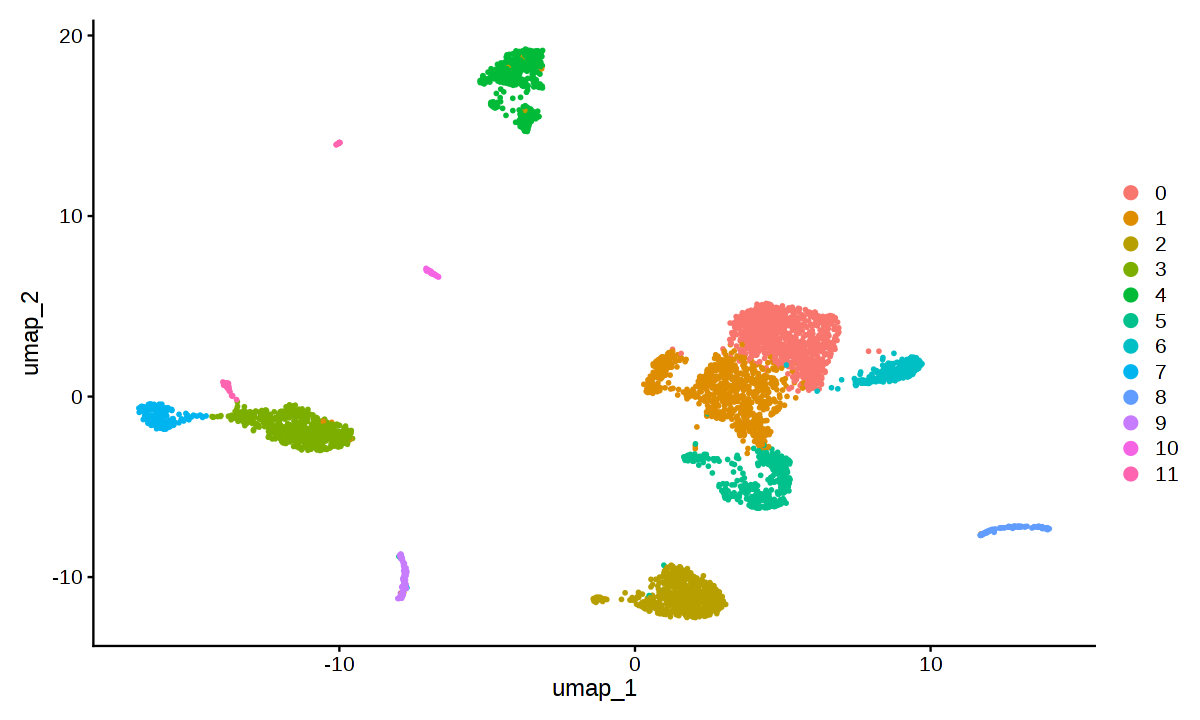

In [50]:
DimPlot(pbmc, reduction = "umap")

## Finding differentially expressed features (cluster biomarkers)


In [51]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE)
pbmc.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1)

Calculating cluster 0

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.000000e+00,2.612691,0.944,0.313,0.000000e+00,0,FHIT
0.000000e+00,2.516684,0.952,0.254,0.000000e+00,0,LEF1
0.000000e+00,2.237676,0.935,0.304,0.000000e+00,0,PRKCQ-AS1
0.000000e+00,1.184164,0.998,0.940,0.000000e+00,0,RPS3A
2.242224e-316,1.149238,0.998,0.933,5.557352e-312,0,RPS13
6.085058e-316,1.088689,0.998,0.948,1.508182e-311,0,RPS14
8.659285e-311,1.094210,0.999,0.948,2.146204e-306,0,RPL30
2.055343e-308,1.086214,0.999,0.944,5.094168e-304,0,RPL34
2.282344e-307,1.099268,0.998,0.938,5.656789e-303,0,RPL9


In [52]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3))
head(cluster5.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CST7,0.000000e+00,8.454013,0.946,0.010,0.000000e+00
GZMA,0.000000e+00,7.631713,0.950,0.019,0.000000e+00
NKG7,0.000000e+00,7.541945,0.991,0.064,0.000000e+00
CCL5,0.000000e+00,7.416700,0.989,0.053,0.000000e+00
MYBL1,2.644088e-288,5.930514,0.853,0.055,6.553373e-284


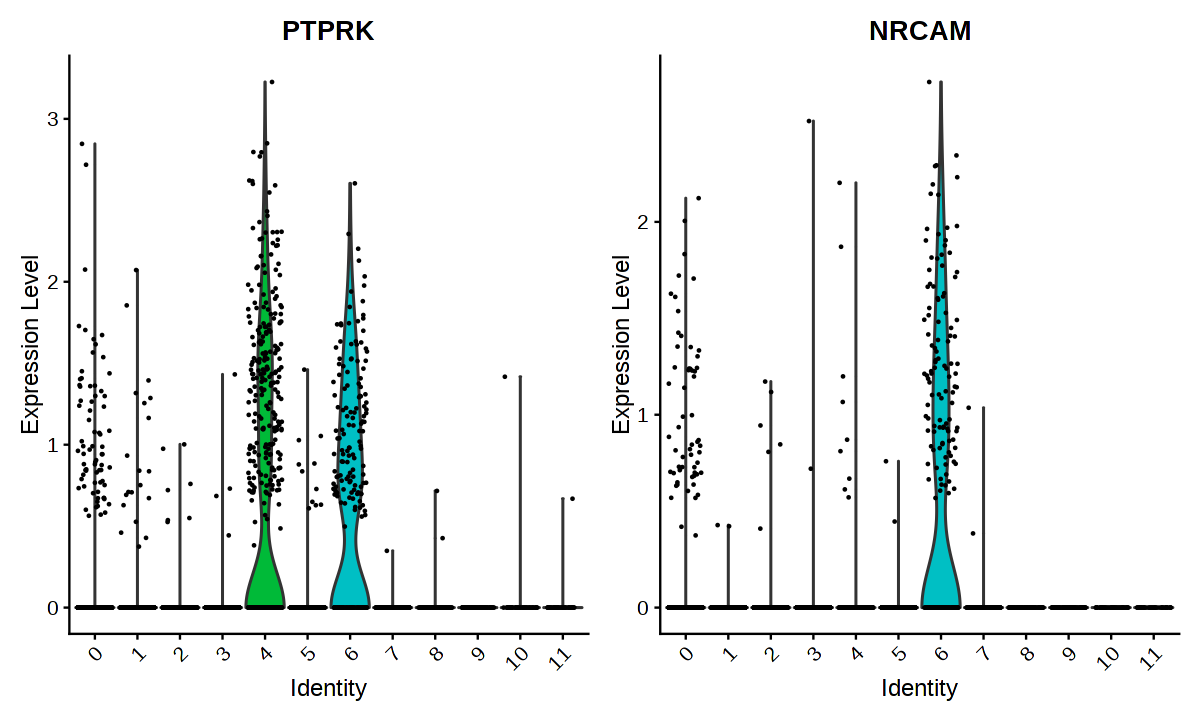

In [53]:
VlnPlot(pbmc, features = c("PTPRK", "NRCAM"))


Warning message:
“The `slot` argument of `VlnPlot()` is deprecated as of Seurat 5.0.0.
ℹ Please use the `layer` argument instead.”


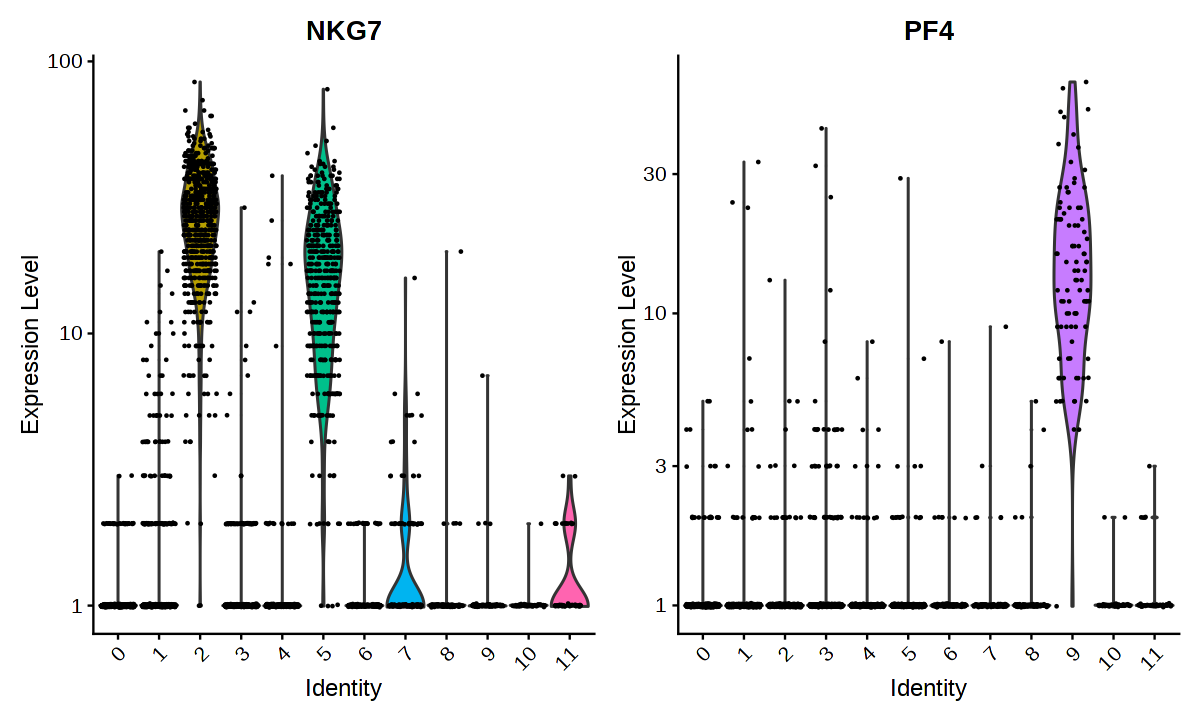

In [54]:
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)


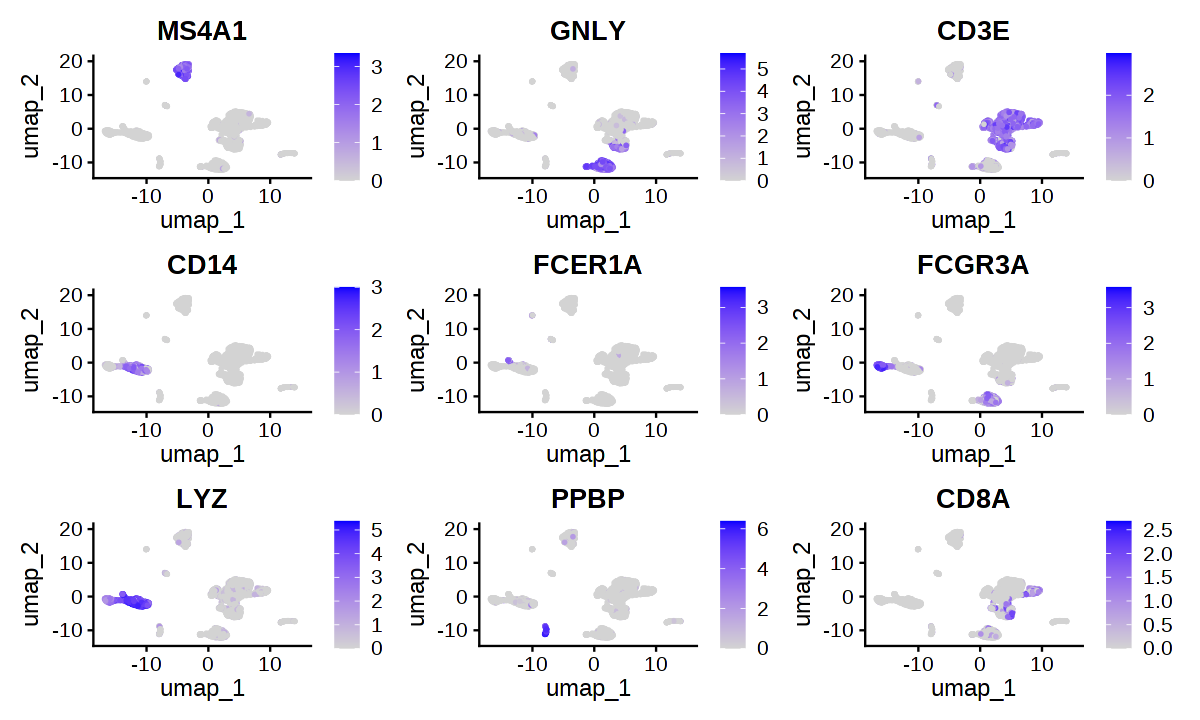

In [55]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",
    "CD8A"))

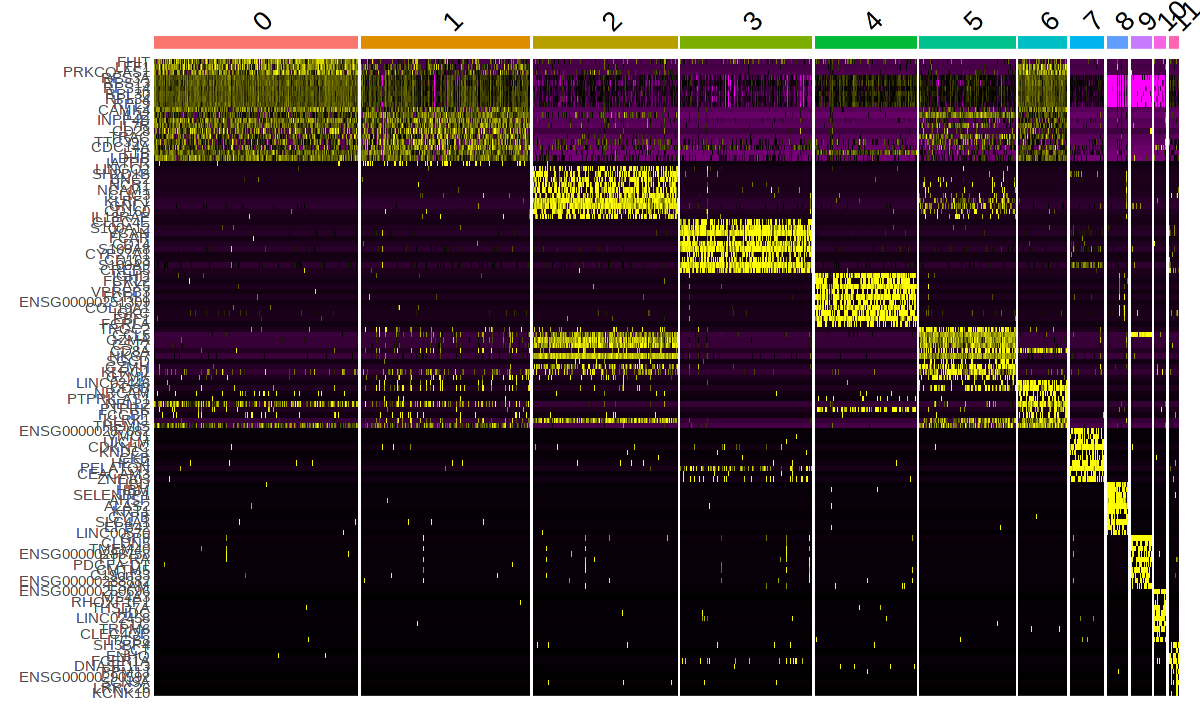

In [56]:
pbmc.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

## Cell type annotation using `SingleR`



In [57]:
library(SingleCellExperiment )

In [58]:
sce <- as.SingleCellExperiment(pbmc)
sce <- scater::logNormCounts(sce)


Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’



In [59]:
sce

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’



class: SingleCellExperiment 
dim: 24785 4559 
metadata(0):
assays(3): counts logcounts scaledata
rownames(24785): ENSG00000238009 ENSG00000241860 ... ENSG00000276345
  ENSG00000278817
rowData names(0):
colnames(4559): AAACCCATCAGATGCT-1 AAACGAAAGTGCTACT-1 ...
  TTTGTTGTCGAAGTGG-1 TTTGTTGTCGCATAGT-1
colData names(8): orig.ident nCount_RNA ... ident sizeFactor
reducedDimNames(2): PCA UMAP
mainExpName: RNA
altExpNames(0):

In [60]:
# Download and cache the normalized expression values of the data
# stored in the Human Primary Cell Atlas. The data will be
#  downloaded from ExperimentHub, returning a SummarizedExperiment
# object for further use.
hpca <- HumanPrimaryCellAtlasData()

# Obtain human bulk RNA-seq data from Blueprint and ENCODE
blueprint <- BlueprintEncodeData()


In [61]:
pred.hpca <- SingleR(test = sce,
      ref = hpca, labels = hpca$label.main)
tab_hpca <- table(pred.hpca$pruned.labels)
write.csv(sort(tab_hpca, decreasing=TRUE), 'pbmc_annotations_HPCA_general.csv', row.names=FALSE)

In [62]:
tab_hpca


           B_cell                BM                DC Endothelial_cells 
              451                30                 1                 1 
     Erythroblast               GMP        HSC_-G-CSF         HSC_CD34+ 
               60                 2                11                 1 
         Monocyte       Neutrophils           NK_cell         Platelets 
              759                39               677                93 
 Pre-B_cell_CD34-           T_cells 
                2              2350 

Each row of the output DataFrame contains prediction results for a single cell. Labels are shown before (labels) and after pruning (pruned.labels), along with the associated scores.

In [63]:
head(pred.hpca)

DataFrame with 6 rows and 4 columns
                                             scores       labels delta.next
                                           <matrix>  <character>  <numeric>
AAACCCATCAGATGCT-1 0.1409902:0.3257687:0.281000:...      T_cells  0.0708860
AAACGAAAGTGCTACT-1 0.1407268:0.3072562:0.264148:...      T_cells  0.6026772
AAACGAAGTCGTAATC-1 0.0604399:0.0725122:0.184863:... Erythroblast  0.1268946
AAACGAAGTTGCCAAT-1 0.1585486:0.3228307:0.278787:...      T_cells  0.6492489
AAACGAATCCGAGGCT-1 0.1166524:0.3565152:0.277855:...       B_cell  0.0505309
AAACGAATCGAACGCC-1 0.1437411:0.3427680:0.299201:...      NK_cell  0.3155681
                   pruned.labels
                     <character>
AAACCCATCAGATGCT-1       T_cells
AAACGAAAGTGCTACT-1       T_cells
AAACGAAGTCGTAATC-1  Erythroblast
AAACGAAGTTGCCAAT-1       T_cells
AAACGAATCCGAGGCT-1        B_cell
AAACGAATCGAACGCC-1       NK_cell

In [64]:
pred.blueprint <- SingleR(test = sce,
      ref = blueprint, labels = blueprint$label.main)
tab_blueprint <- table(pred.blueprint$pruned.labels)
  write.csv(sort(tab_blueprint, decreasing=TRUE), 'pbmc_annotations_BlueprintENCODE_general.csv', row.names=FALSE)

In [65]:
tab_blueprint


          B-cells      CD4+ T-cells      CD8+ T-cells                DC 
              455              1749               576                 3 
Endothelial cells       Eosinophils      Erythrocytes               HSC 
                1                50               128                 4 
        Monocytes       Neutrophils          NK cells 
              768                 3               692 

In [66]:
head(pred.blueprint)

DataFrame with 6 rows and 4 columns
                                             scores       labels delta.next
                                           <matrix>  <character>  <numeric>
AAACCCATCAGATGCT-1 0.2145648:0.1136181:0.437872:... CD4+ T-cells  0.0512150
AAACGAAAGTGCTACT-1 0.2311086:0.1664737:0.393066:... CD4+ T-cells  0.3283657
AAACGAAGTCGTAATC-1 0.0977069:0.0728724:0.100641:... Erythrocytes  0.0757261
AAACGAAGTTGCCAAT-1 0.2289000:0.1565938:0.423090:... CD8+ T-cells  0.0620951
AAACGAATCCGAGGCT-1 0.2353403:0.1291495:0.500443:...      B-cells  0.1276654
AAACGAATCGAACGCC-1 0.2308036:0.1288775:0.417440:...     NK cells  0.1486502
                   pruned.labels
                     <character>
AAACCCATCAGATGCT-1  CD4+ T-cells
AAACGAAAGTGCTACT-1  CD4+ T-cells
AAACGAAGTCGTAATC-1  Erythrocytes
AAACGAAGTTGCCAAT-1  CD8+ T-cells
AAACGAATCCGAGGCT-1       B-cells
AAACGAATCGAACGCC-1      NK cells

In [67]:
pbmc$singleR_hpca = pred.hpca$pruned.labels
pbmc$singleR_blueprint = pred.blueprint$pruned.labels

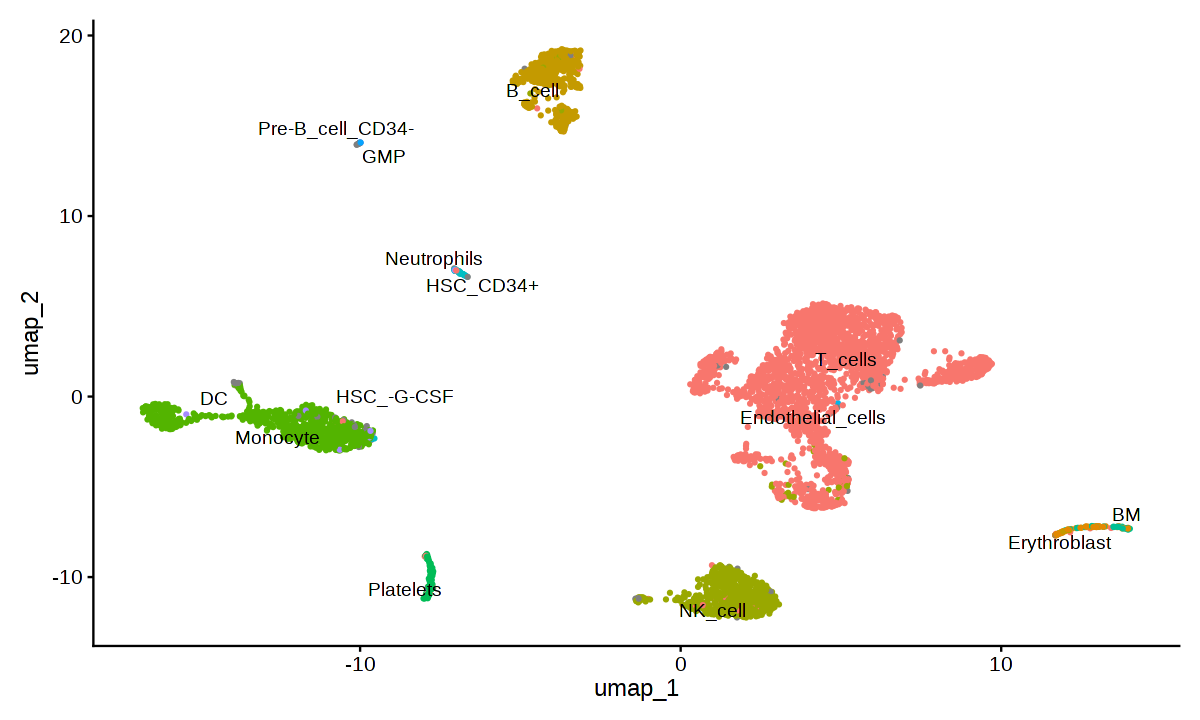

In [69]:
Idents(pbmc) = pbmc$singleR_hpca
DimPlot(pbmc, reduction = "umap",
         label = TRUE, pt.size = 0.5,
          repel = TRUE) + NoLegend()
# Change back to cluster snn_res.0.1
Idents(pbmc) = pbmc$`RNA_snn_res.0.2`

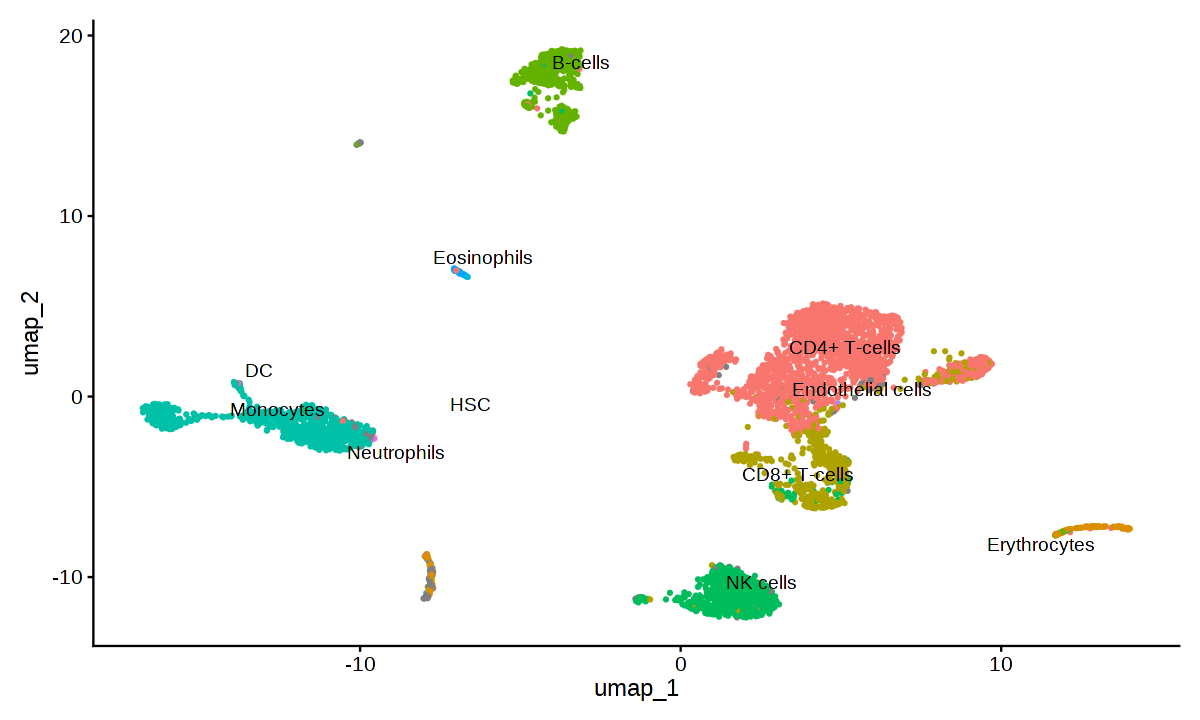

In [70]:
Idents(pbmc) = pbmc$singleR_blueprint
DimPlot(pbmc, reduction = "umap",
         label = TRUE, pt.size = 0.5,
          repel = TRUE) + NoLegend()
# Change back to cluster snn_res.0.2
Idents(pbmc) = pbmc$`RNA_snn_res.0.2`

## Manual annotation

| Markers       | Cell Type    |
|---------------|--------------|
| IL7R, CCR7    | Naive CD4+ T |
| CD14, LYZ     | CD14+ Mono   |
| IL7R, S100A4  | Memory CD4+  |
| MS4A1         | B            |
| CD8A          | CD8+ T       |
| FCGR3A, MS4A7 | FCGR3A+ Mono |
| GNLY, NKG7    | NK           |
| FCER1A, CST3  | DC           |
| PPBP          | Platelet     |

In [72]:
table(Idents(pbmc))


  0   1   2   3   4   5   6   7   8   9  10  11 
934 777 662 604 465 442 224 157  98  94  54  48 

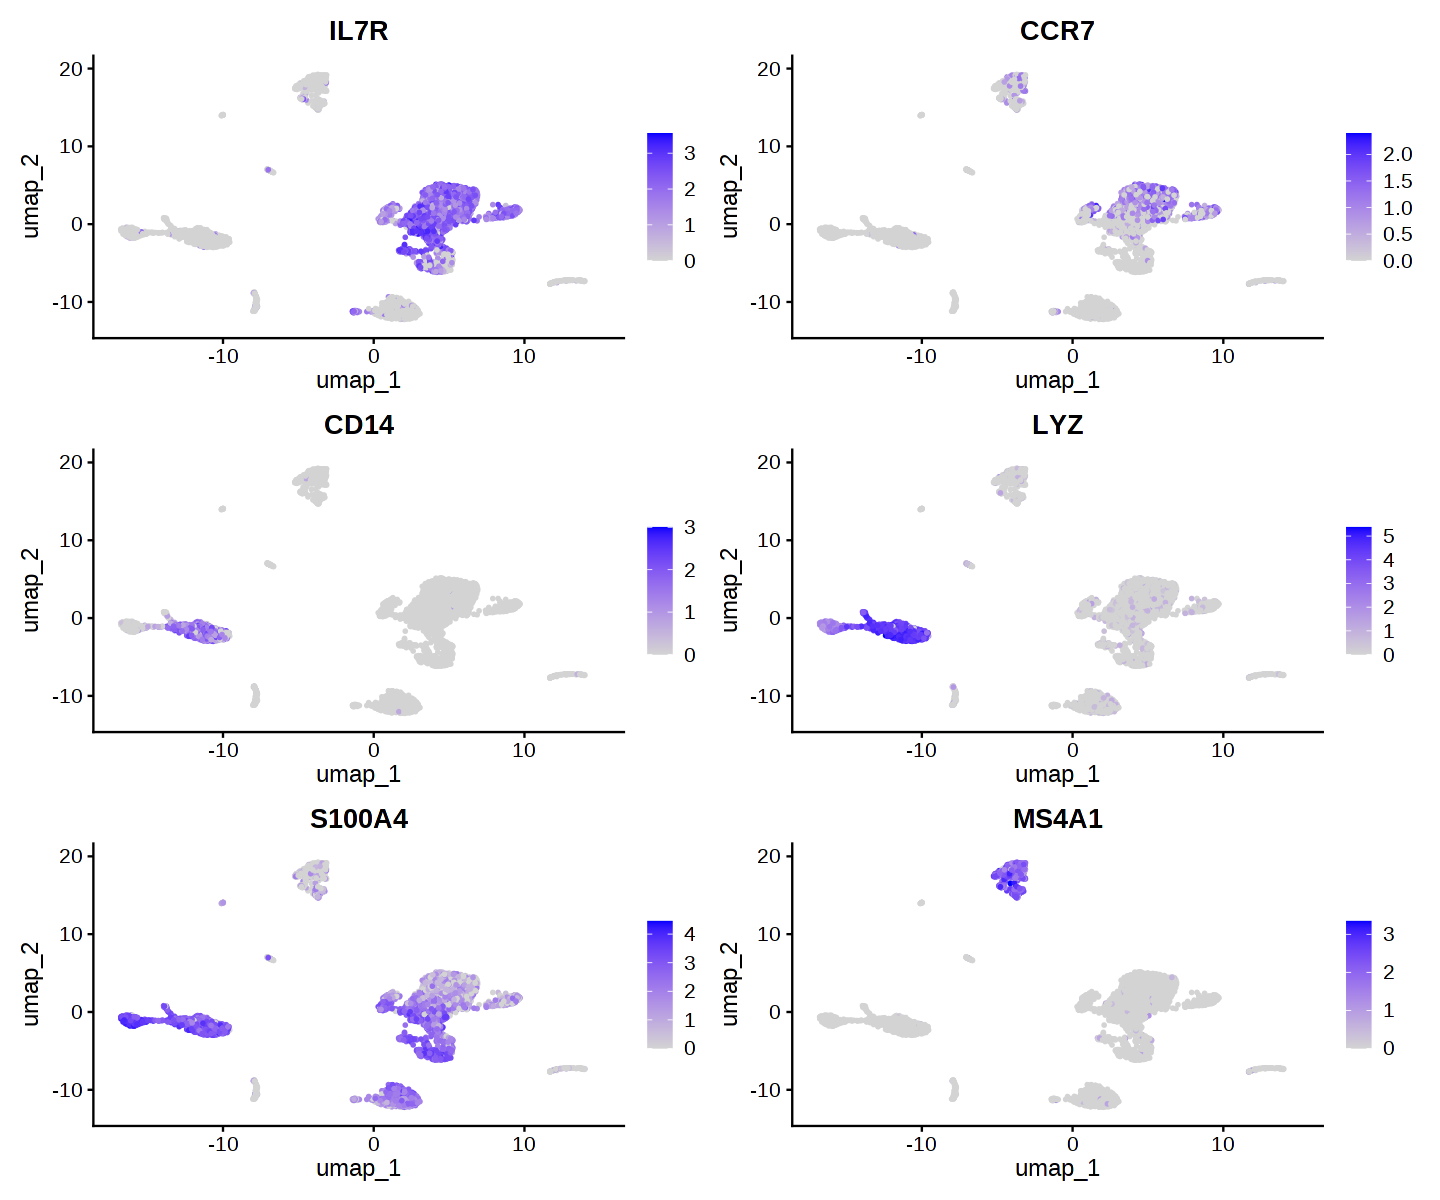

In [82]:
options(repr.plot.width=12, repr.plot.height= 10)
FeaturePlot(pbmc, features = c("IL7R", "CCR7", "CD14", "LYZ", "S100A4", "MS4A1"))

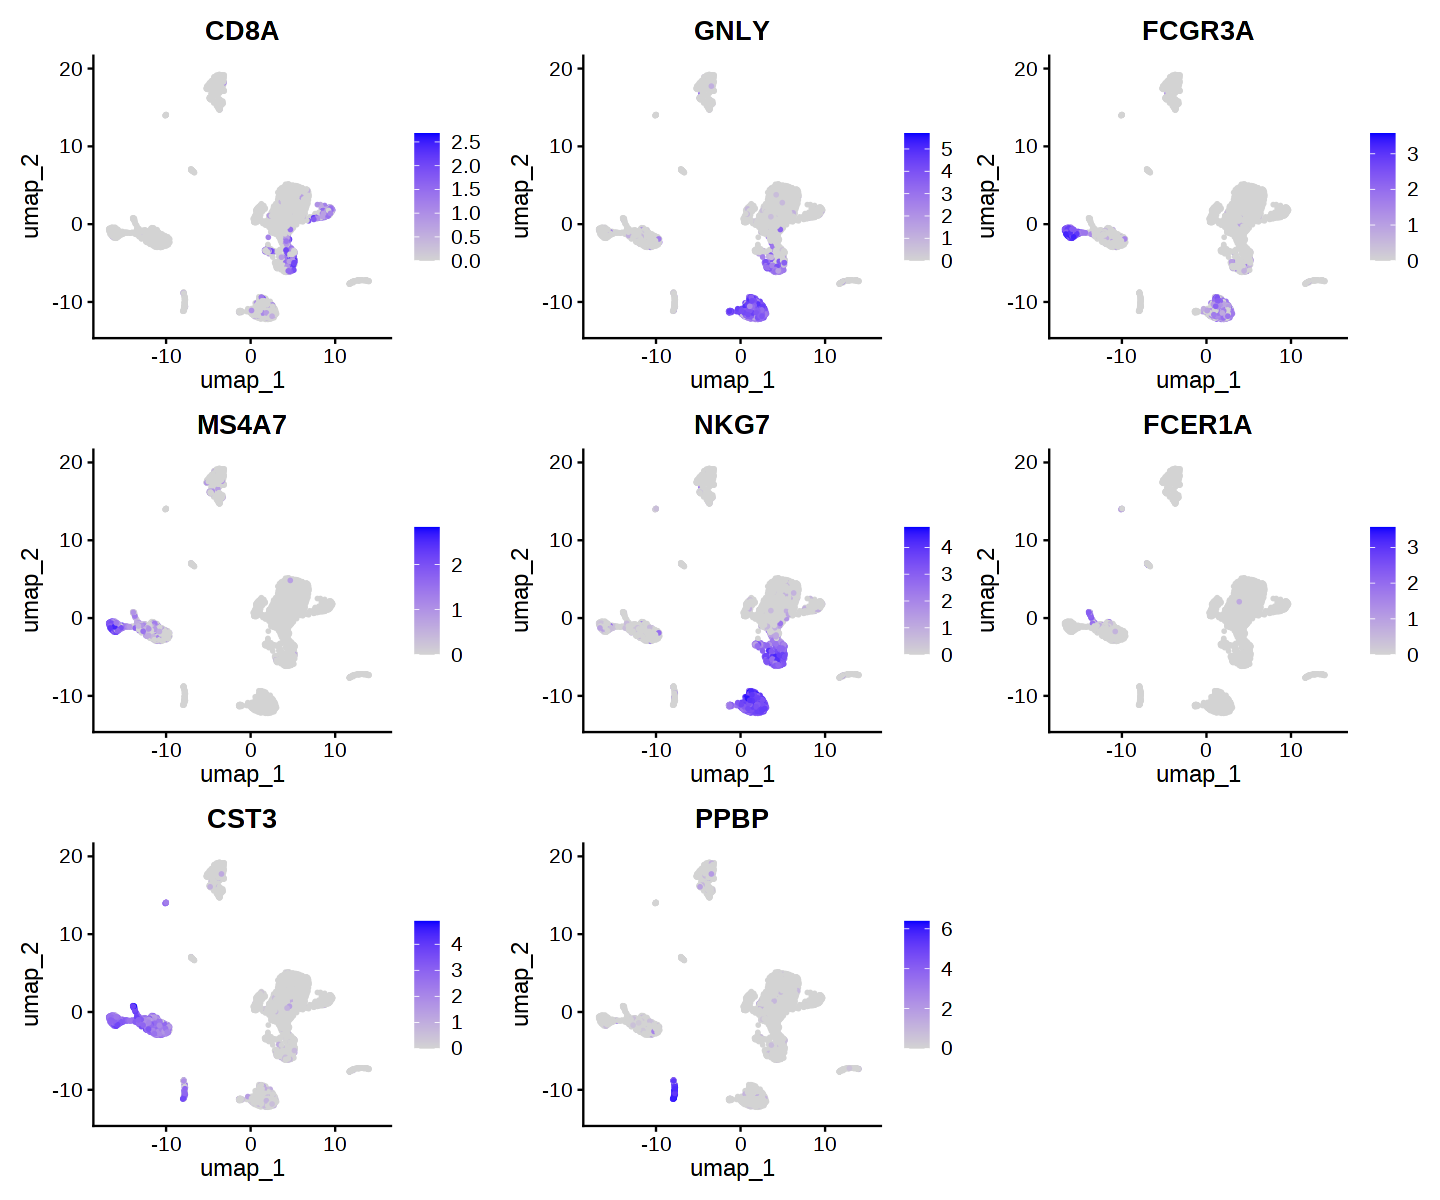

In [81]:
# CD8A	          CD8+ T
# FCGR3A, MS4A7	  FCGR3A+ Mono
# GNLY, NKG7	    NK
# FCER1A, CST3	  DC
# PPBP	          Platelet
FeaturePlot(pbmc, features = c("CD8A", "GNLY", "FCGR3A", "MS4A7", "GNLY", "NKG7",  "FCER1A", "CST3", "PPBP"))

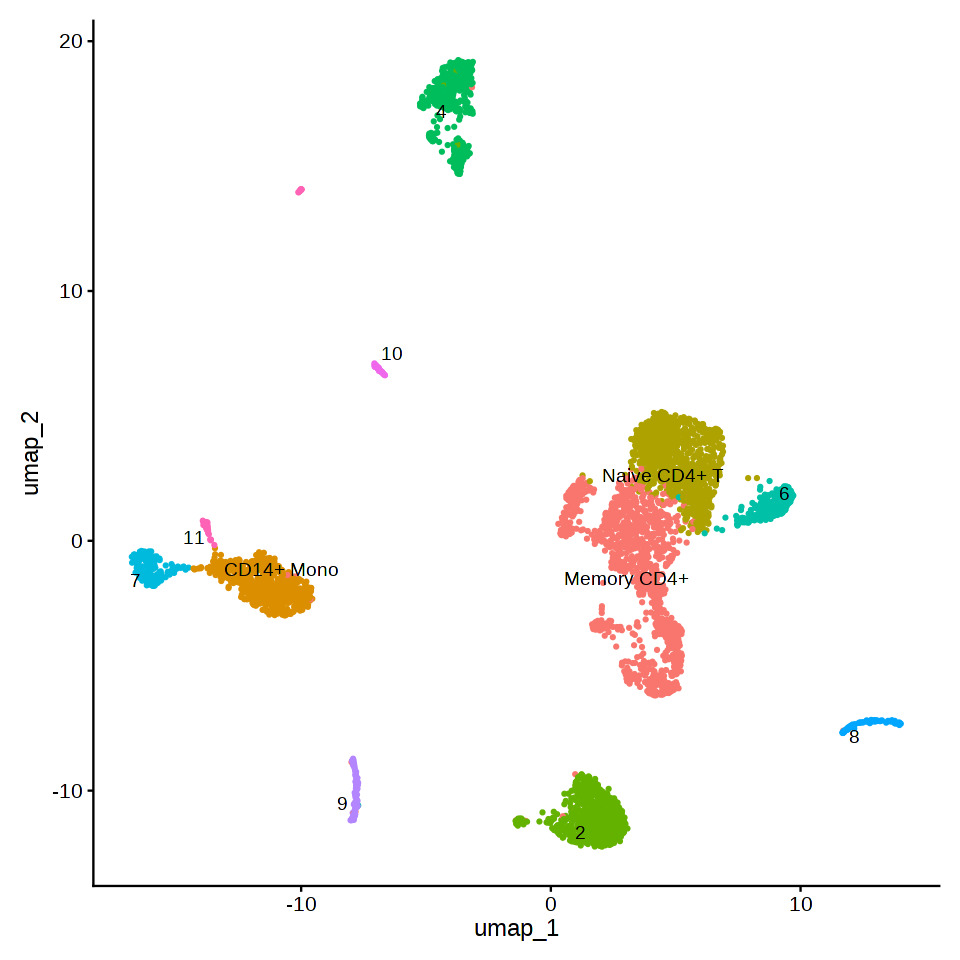

In [90]:
options(repr.plot.width=8, repr.plot.height= 8)
DimPlot(pbmc, reduction = "umap",
         label = TRUE, pt.size = 0.5,
          repel = TRUE) + NoLegend()

In [88]:
pbmc = RenameIdents(pbmc, "0"="Naive CD4+ T")
pbmc = RenameIdents(pbmc, "3"="CD14+ Mono")
pbmc = RenameIdents(pbmc, "1"="Memory CD4+")
pbmc = RenameIdents(pbmc, "5"="Memory CD4+")
### Add more manual annotation based on your checking


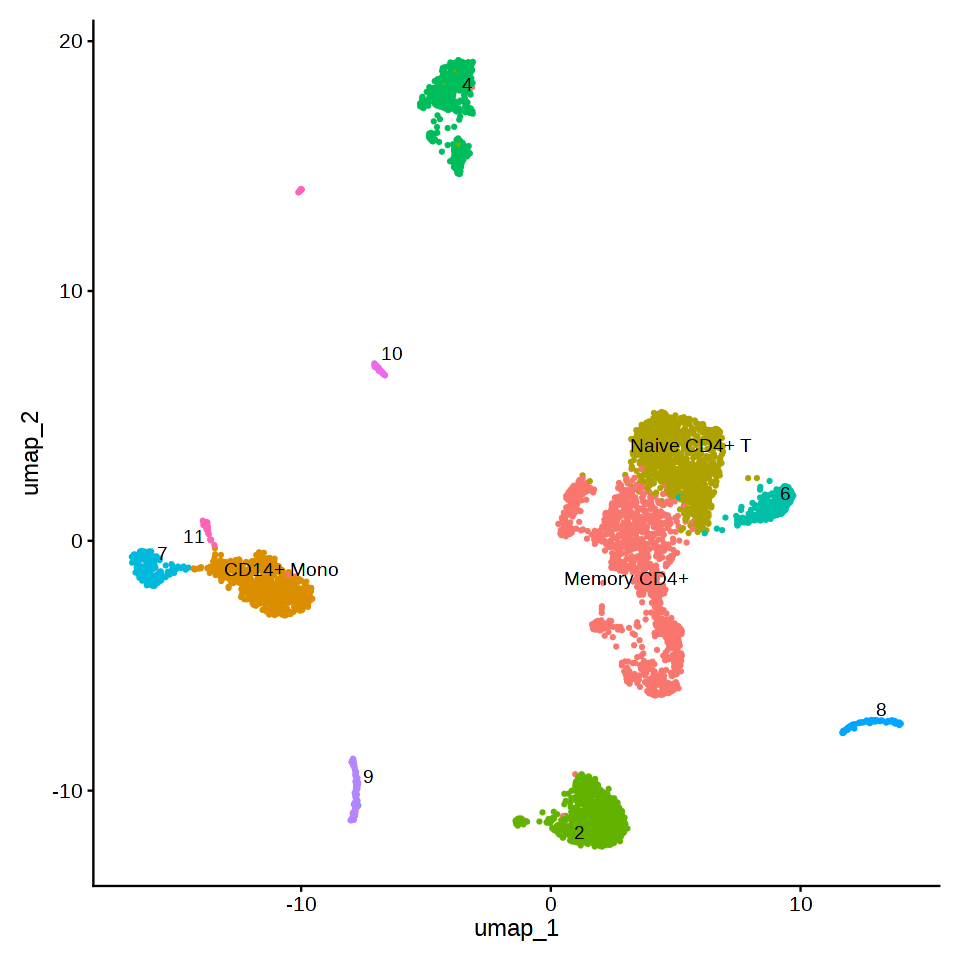

In [91]:
options(repr.plot.width=8, repr.plot.height= 8)
DimPlot(pbmc, reduction = "umap",
         label = TRUE, pt.size = 0.5,
          repel = TRUE) + NoLegend()

## Save the Seurat object

In [92]:
saveRDS(pbmc, file = "Seurat_object_pbmc_final.rds")

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’



## Use Loupe Browser to visualize and analyze the data

Loupe Browser is a powerful visualization software that provides the intuitive functionality you need to explore and analyze your 10x Genomics Chromium and Visium data. You can also convert your Seurat objects into Loupe Browser files using the LoupeR package.


### Step 1: convert the seurat object to `cloupe` file

10x Genomics' LoupeR is an R package that works with Seurat objects to create a Loupe Browser file. The Loupe Browser file can then be imported into Loupe Browser (v7.0 or later) for data visualization and further exploration.

In [ ]:
#remotes::install_github("10xGenomics/loupeR")
#loupeR::setup()

In [93]:
library(loupeR)

Warning message in fun(libname, pkgname):
“Please call `loupeR::setup()` to install the Louper executable  and to agree to the EULA before continuing”


In [94]:
loupeR::setup()


Installing Executable



2025/12/06 03:16:13 Downloading executable



The LoupeR executable is subject to the 10x End User Software License, available at:
https://10xgen.com/EULA 

Do you accept the End-User License Agreement
(y/yes or n/no): yes

EULA



In [95]:
create_loupe_from_seurat(pbmc, output_name = "Seurat_object_pbmc_cloupe")


2025/12/06 03:16:18 extracting matrix, clusters, and projections

2025/12/06 03:16:19 selected assay: RNA

2025/12/06 03:16:19 selected clusters: active_cluster orig.ident RNA_snn_res.0.2 seurat_clusters singleR_hpca singleR_blueprint

2025/12/06 03:16:19 selected projections: umap

2025/12/06 03:16:19 validating count matrix

2025/12/06 03:16:19 validating clusters

2025/12/06 03:16:19 validating projections

2025/12/06 03:16:19 creating temporary hdf5 file: /tmp/Rtmp3eevui/file1b12091afba.h5

2025/12/06 03:16:24 invoking louper executable

2025/12/06 03:16:24 running command: "/root/.local/share/R/loupeR/louper create --input='/tmp/Rtmp3eevui/file1b12091afba.h5' --output='Seurat_object_pbmc_cloupe.cloupe'"



In [96]:
sessionInfo()

R version 4.5.2 (2025-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] loupeR_1.1.4                future_1.68.0              
 [3] scater_1.38.0               ggplot2_4.0.1              
 [5] scuttle_1.20.0              SingleCell

## Reference

https://monashbioinformaticsplatform.github.io/Single-Cell-Workshop/pbmc3k_tutorial.html

https://bioinformatics.ccr.cancer.gov/docs/getting-started-with-scrna-seq/IntroToR_Seurat/

https://hbctraining.github.io/scRNA-seq/lessons/elbow_plot_metric.html


